In [56]:
import torch

device = device = torch.device('cuda', 0)
# or
device = device = torch.device('cuda:0')
# or if just one GPU...
device = device = torch.device('cuda')
# Data parallelism with many GPUs is also doable.

In [67]:
# Let's make some data
X = torch.rand(1001) * 10
y = 0.72826 * X + 0.72826 + torch.randn_like(X) * 0.1
y = 0.72826 * X - 1 + torch.randn_like(X) * 0.1

# Models extend torch.nn.module
# Define parameters and attributes in constructor
# And implement a .forward()
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # Attributes with are Modules or Parameters will be
        # grouped into model.parameters().
        self.weight = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
        self.bias = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
        
        # We can also have other attributes.
        self.coin = torch.distributions.bernoulli.Bernoulli(torch.tensor([0.5]))

    def flip(self):
        return self.coin.sample().item() == 1.

    # Use weights and bias interchangably.
    # Swap them with a coin flip each time.
    def forward(self, x):
        if self.flip():
            return self.weight * x + self.bias
        else:
            return self.bias * x + self.weight

# Make a model instance
my_model = Model().to(device)

print('Initial:')
print(my_model.weight.item(), my_model.bias.item())

# Construct an optimiser
optimiser = torch.optim.SGD(my_model.parameters(), lr=1e-4)

# Batch gradient descent
losses = []
for i in range(1000):
    # Need to make sure data is on the right device
    X, y = X.to(device), y.to(device)
    
    # Gradients accumulate in PyTorch, zero them out.
    optimiser.zero_grad()
    output = my_model(X)
    loss = torch.mean((output - y)**2)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

print('Final:')
print(my_model.weight.item(), my_model.bias.item())

Initial:
0.0 0.0
Final:
0.4962029755115509 0.4812025725841522


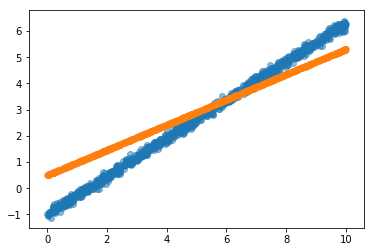

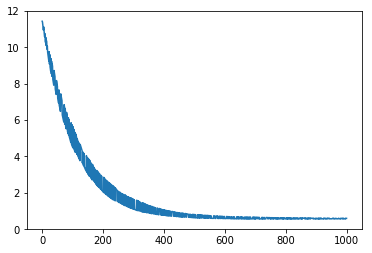

In [68]:
from matplotlib import pyplot as plt
plt.figure()
plt.scatter(X.to('cpu').numpy(), y.to('cpu').numpy(), alpha=0.5)
plt.scatter(X.to('cpu').numpy(), output.detach().to('cpu').numpy(), alpha=0.5)
plt.figure()
plt.plot(losses)

15 steps to norm: 112448.12


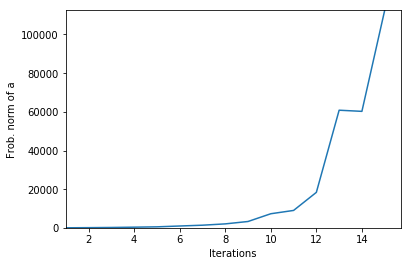

In [70]:
from itertools import count
N = 100
threshold = 100000
a = torch.randn(N, N).to(device)
norms = []
for index in count(1):
    a = a * (1 + torch.randn(N, N).to(device)*1.1)
    norm = a.norm().item()
    norms.append(norm)
    if norm >= threshold:
        break
print("{} steps to norm: {:.2f}".format(index, norm))
plt.plot(torch.arange(1, len(norms)+1).numpy(), norms)
plt.xlim(xmin=1)
plt.ylim(ymin=min(norms), ymax=max(norms))
plt.xlabel('Iterations')
plt.ylabel('Frob. norm of a')
plt.show()